# Flight Analysis Tool

This notebook analyzes a specific flight by:
1. Displaying TVTW (Traffic Volume Time Window) information for the flight
2. Plotting the flight trajectory and impacted traffic volumes

**Usage:** Enter a flight_identifier to analyze the flight's traffic volume impacts.

In [1]:
import json
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point, LineString
import sys
import os

# Add the project source to path for imports
sys.path.append('../src')
from project_tailwind.impact_eval.tvtw_indexer import TVTWIndexer

plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)

## User Input

Enter the flight_identifier you want to analyze:

In [2]:
# USER INPUT: Enter the flight_identifier to analyze
flight_identifier = "263871294"  # Example flight ID - change this to analyze different flights

print(f"Analyzing flight: {flight_identifier}")

Analyzing flight: 263871294


In [3]:
## Load Required Data

In [5]:
# Load impact vectors
with open('../output/so6_occupancy_matrix.json', 'r') as f:
    impact_vectors = json.load(f)

# Load traffic volumes
traffic_volumes = gpd.read_file('/Volumes/CrucialX/project-cirrus/cases/traffic_volumes_simplified.geojson')

# Load TVTW indexer
tvtw_indexer = TVTWIndexer.load('../output/tvtw_indexer.json')

# Load CSV trajectory data for the specific flight
trajectory_df = pd.read_csv('/Volumes/CrucialX/project-cirrus/cases/flights_20230801.csv')

print(f"Loaded {len(impact_vectors)} flights with impact vectors")
print(f"Loaded {len(traffic_volumes)} traffic volumes")
print(f"TVTW indexer: {len(tvtw_indexer._tv_id_to_idx)} traffic volumes, {tvtw_indexer.time_bin_minutes}min bins")
print(f"Loaded {len(trajectory_df)} trajectory segments")

Skipping field elementary_sectors: unsupported OGR type: 5


Loaded 21444 flights with impact vectors
Loaded 622 traffic volumes
TVTW indexer: 622 traffic volumes, 15min bins
Loaded 1214748 trajectory segments


In [6]:
## Analysis Functions

In [7]:
def analyze_flight_tvtws(flight_id, impact_vectors, tvtw_indexer):
    """
    Print TVTW information for a given flight identifier
    """
    flight_id_str = str(flight_id)
    
    if flight_id_str not in impact_vectors:
        print(f"❌ Flight {flight_id} not found in impact vectors")
        return None
    
    impact_vector = impact_vectors[flight_id_str]
    print(f"✅ Flight {flight_id} found with {len(impact_vector)} traffic volume impacts\n")
    print("TVTW Information:")
    print("=" * 60)
    
    tvtw_info = []
    for impact_idx in impact_vector:
        tvtw_data = tvtw_indexer.get_human_readable_tvtw(impact_idx)
        if tvtw_data:
            tv_id, time_window = tvtw_data
            tvtw_info.append({
                'traffic_volume_id': tv_id,
                'time_window': time_window,
                'impact_index': impact_idx
            })
    
    # Sort by time window for better readability
    tvtw_info.sort(key=lambda x: x['time_window'])
    
    # Print sorted TVTW information
    for tvtw_data in tvtw_info:
        print(f"Traffic Volume: {tvtw_data['traffic_volume_id']:12} | Time Window: {tvtw_data['time_window']}")
    
    print(f"\n📊 Total impacted traffic volumes: {len(set([t['traffic_volume_id'] for t in tvtw_info]))}")
    print(f"📊 Total TVTW impacts: {len(tvtw_info)}")
    
    return tvtw_info

def get_flight_trajectory(flight_id, trajectory_df):
    """
    Extract flight trajectory from CSV data
    """
    if isinstance(flight_id, str):
        flight_id = int(flight_id)
    flight_segments = trajectory_df[trajectory_df['flight_identifier'] == flight_id].copy()
    
    if flight_segments.empty:
        print(f"❌ No trajectory data found for flight {flight_id}")
        return None
    
    # Sort by sequence
    flight_segments = flight_segments.sort_values('sequence')
    
    # Create trajectory coordinates
    coordinates = []
    first_segment = flight_segments.iloc[0]
    coordinates.append((first_segment['longitude_begin'], first_segment['latitude_begin']))
    
    for _, segment in flight_segments.iterrows():
        coordinates.append((segment['longitude_end'], segment['latitude_end']))
    
    # Create trajectory geometry
    trajectory_geom = LineString(coordinates)
    
    # Get flight metadata
    flight_info = {
        'flight_identifier': flight_id,
        'call_sign': first_segment['call_sign'],
        'origin': first_segment['origin_aerodrome'],
        'destination': first_segment['destination_aerodrome'],
        'geometry': trajectory_geom,
        'num_segments': len(flight_segments)
    }
    
    return flight_info

In [8]:
def plot_flight_analysis(flight_id, tvtw_info, flight_trajectory, traffic_volumes):
    """
    Plot flight trajectory and impacted traffic volumes
    """
    if not tvtw_info or not flight_trajectory:
        print("❌ Cannot create plot - missing flight data")
        return
    
    # Get impacted traffic volume IDs
    impacted_tv_ids = set([t['traffic_volume_id'] for t in tvtw_info])
    
    # Filter traffic volumes to only impacted ones
    impacted_tvs = traffic_volumes[traffic_volumes['traffic_volume_id'].isin(impacted_tv_ids)]
    
    print(f"\n🗺️  Creating visualization for flight {flight_id}")
    print(f"   ✈️  Trajectory: {flight_trajectory['call_sign']} ({flight_trajectory['origin']} → {flight_trajectory['destination']})")
    print(f"   🏢 Impacted traffic volumes: {len(impacted_tvs)}")
    
    # Create the plot
    fig = plt.figure(figsize=(15, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Calculate bounds from trajectory and traffic volumes
    traj_bounds = flight_trajectory['geometry'].bounds
    if not impacted_tvs.empty:
        tv_bounds = impacted_tvs.total_bounds
        min_lon = min(traj_bounds[0], tv_bounds[0]) - 1
        max_lon = max(traj_bounds[2], tv_bounds[2]) + 1
        min_lat = min(traj_bounds[1], tv_bounds[1]) - 1
        max_lat = max(traj_bounds[3], tv_bounds[3]) + 1
    else:
        min_lon, min_lat, max_lon, max_lat = traj_bounds
        min_lon -= 1; max_lon += 1; min_lat -= 1; max_lat += 1
    
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, alpha=0.3, color='lightgray')
    ax.add_feature(cfeature.OCEAN, alpha=0.3, color='lightblue')
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, alpha=0.3)
    gl.top_labels = False
    gl.right_labels = False
    
    # Plot impacted traffic volumes
    if not impacted_tvs.empty:
        impacted_tvs.plot(
            ax=ax,
            facecolor='red',
            edgecolor='darkred',
            alpha=0.6,
            linewidth=1.5,
            label=f'Impacted Traffic Volumes ({len(impacted_tvs)})'
        )
        
        # Add traffic volume labels
        for _, tv in impacted_tvs.iterrows():
            centroid = tv.geometry.centroid
            ax.text(
                centroid.x, centroid.y,
                tv['traffic_volume_id'],
                transform=ccrs.PlateCarree(),
                ha='center', va='center',
                fontsize=8, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
            )
    
    # Plot flight trajectory
    trajectory_coords = list(flight_trajectory['geometry'].coords)
    lons, lats = zip(*trajectory_coords)
    
    ax.plot(lons, lats, 
            color='blue', linewidth=3, alpha=0.8,
            transform=ccrs.PlateCarree(), 
            label=f"Flight {flight_id} ({flight_trajectory['call_sign']})")
    
    # Mark start and end points
    ax.plot(lons[0], lats[0], 'go', markersize=8, transform=ccrs.PlateCarree(), label='Start')
    ax.plot(lons[-1], lats[-1], 'ro', markersize=8, transform=ccrs.PlateCarree(), label='End')
    
    plt.title(f'Flight {flight_id} Analysis\n'
              f'{flight_trajectory["call_sign"]}: {flight_trajectory["origin"]} → {flight_trajectory["destination"]}\n'
              f'Impacted {len(impacted_tvs)} traffic volumes', 
              fontsize=14, fontweight='bold')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

## Flight Analysis

In [9]:
# Step 1: Analyze TVTW information for the flight
tvtw_info = analyze_flight_tvtws(flight_identifier, impact_vectors, tvtw_indexer)

✅ Flight 263871294 found with 5 traffic volume impacts

TVTW Information:
Traffic Volume: EDMFUE       | Time Window: 12:30-12:45
Traffic Volume: EDMSTA       | Time Window: 12:30-12:45
Traffic Volume: EDMTEG       | Time Window: 12:30-12:45
Traffic Volume: EDMFUE       | Time Window: 12:45-12:60
Traffic Volume: EDMILR       | Time Window: 12:45-12:60

📊 Total impacted traffic volumes: 4
📊 Total TVTW impacts: 5


In [10]:
# Step 2: Get flight trajectory from CSV data
flight_trajectory = get_flight_trajectory(flight_identifier, trajectory_df)

if flight_trajectory:
    print(f"\n✈️  Flight Trajectory Information:")
    print(f"   Call Sign: {flight_trajectory['call_sign']}")
    print(f"   Route: {flight_trajectory['origin']} → {flight_trajectory['destination']}")
    print(f"   Segments: {flight_trajectory['num_segments']}")
else:
    print("❌ No trajectory data found")


✈️  Flight Trajectory Information:
   Call Sign: 6619
   Route: BKPR → EDJA
   Segments: 45



🗺️  Creating visualization for flight 263871294
   ✈️  Trajectory: 6619 (BKPR → EDJA)
   🏢 Impacted traffic volumes: 4


/var/folders/8k/_h2zg_z51q9fpsbmsh42bd3h0000gn/T/ipykernel_3717/183901131.py:88: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper left')


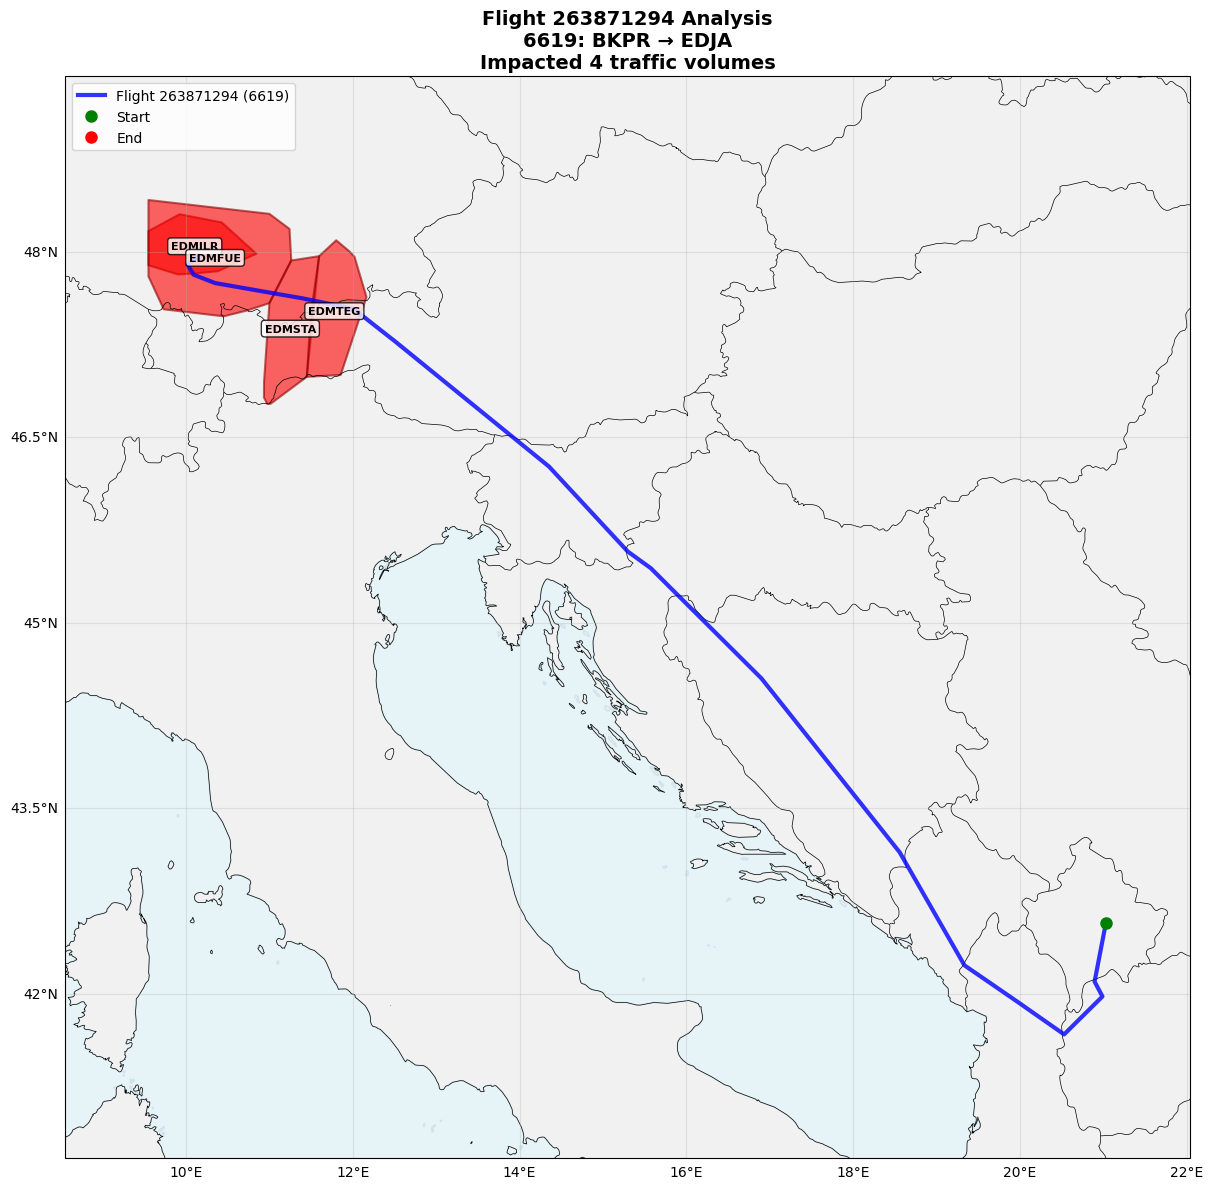

In [11]:
# Step 3: Create visualization
plot_flight_analysis(flight_identifier, tvtw_info, flight_trajectory, traffic_volumes)